<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/LSTN%E3%81%AB%E3%82%88%E3%82%8B%E6%AF%8E%E9%80%B1%E3%81%AE%E6%B0%97%E6%B8%A9%E4%BA%88%E6%B8%AC(%E5%A4%89%E6%95%B0%E3%81%AE%E8%80%83%E6%85%AE%E7%84%A1%E3%81%97).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[参考動画](https://www.youtube.com/watch?v=y-XvMZq33c4&t=2159s)

[元データはこちら](https://analysis-navi.com/?p=3868)

[清書元はこちら](https://colab.research.google.com/drive/1ya_JNmBPyGlFfK0-fvR6nVXfBAycTyyA#scrollTo=3-0WKomXN_oa)

In [ ]:
#いろいろインポート
import tensorflow as tf #ディープラーニング用
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

### データ読込と確認


In [ ]:
df = pd.read_csv("/content/LSTNによる毎週の気温予測(変数の考慮無し).csv",index_col="年月日",encoding="shift_jis",parse_dates=True)
df.head(4)

,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2010-01-01,4.8,0.0,9.2
2010-01-02,6.3,0.0,9.0
2010-01-03,5.7,0.0,6.6
2010-01-04,6.5,0.0,5.2


今回はLSTNの変数無しなので[<font color="red">降水量の合計(mm),	日照時間(時間)</font>]をドロップします。

In [ ]:
df = df[["平均気温(℃)"]]
df.head(5)

,平均気温(℃)
年月日,
2010-01-01,4.8
2010-01-02,6.3
2010-01-03,5.7
2010-01-04,6.5
2010-01-05,7.3


列(カラム)が多すぎるので、今回は月ごとの平均にまとめます。groupbyのように。

In [ ]:
df = df.resample("M").mean() #週ごとに集計
df

,平均気温(℃)
年月日,
2010-01-31,7.022581
2010-02-28,6.500000
2010-03-31,9.096774
2010-04-30,12.393333
2010-05-31,18.951613
...,...
2019-08-31,28.396774
2019-09-30,25.060000
2019-10-31,19.425806


### データ正規化と分割

ディープラーニング用に<font color="red">0〜1にスケーリング</font>。

すべての値を0～1の範囲に収めます。-30°や20°も全て0～1の範囲に収め、dfに格納し直します。

<font color="red">何故そんなことを？</font>

ディープラーニングの時系列分析の際は、細かい事は気にせずにこういうものだと割り切ってもらえれば。後で調べます。

In [ ]:
#その為のモジュールをインポート
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)) # 範囲設定

# fitさせます。dfの要素をscalerに適合させindexとcloumnsも指定します。
df_scale = pd.DataFrame(scaler.fit_transform(df),index=df.index,columns=df.columns)


# 確認 ⇒ 平均気温(℃) が0～1 の範囲に収まっているでしょう。
df_scale.head()

,平均気温(℃)
年月日,
2010-01-31,0.094783
2010-02-28,0.073864
2010-03-31,0.177815
2010-04-30,0.309780
2010-05-31,0.572314


データ分割。LSTN用のデータ分割です。

In [ ]:
look_back = 30 #どれくらい過去まで見るか

def create_input_data(data, look_back):    
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))] 
    y = [[] for i in range(len(raw_data))] 

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]
    
    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)
    
    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))
    
    return y, X
    

In [ ]:
y_train,X_train = create_input_data(
    data=df_scale,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=df_scale,
    look_back=look_back
)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((90, 30, 1), (90, 1, 1), (90, 30, 1), (90, 1, 1))

### モデルの定義と学習
⇒質問

In [ ]:
# 各モジュールへのインポート。
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

input shape というのは決まってます。こういうものだと。
そしてLSTMのユニットをいくつ作成するか。

⇒最善が分からないので<font color="red">試行錯誤して結果を確認しながら調整</font>しましょう。手間ですけど。

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((90, 30, 1), (90, 1, 1), (90, 30, 1), (90, 1, 1))

In [ ]:
# モデルのインスタンス化
model = Sequential()


x = model.add(LSTM(4, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(8))
model.add(Dense(len(df.columns))) #出力層はデータ数に合わせる

学習実行

<font color="red">エポックは何週するのか？</font>一応学習すればするほど、どんどん誤差が小さくなってきて頭打ちになるはずです。その頭打ちを狙いましょう。

<font color="red">バッチサイズ</font>はデータを一気に入れると大変だからどのくらい小分けにするの？という話。

時間を取るかメモリ効率を取るか。⇒画像とやると1000とか回す必要がある。

損失関数の設定。数値を予測するときは､平方二乗誤差。⇒評価値。小さいほど良いです。

optimizer⇒基本的には分からないので<font color="red">試行錯誤</font>して結果を確認しながら調整しましょう。他候補は、SGD AdaGrad 等

これがないと下記がエラーになります。
⇒

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

```
history = model.fit(X_train, y_train, epochs=50, batch_size=1)
```

多分だけど、学習するときのどの基準を定めるのだと思う。
<font color="red">rmse</font>を良い結果にしたいです。みたいな。


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# ハイパーパラメータ
batch_size = 128  # バッチサイズ 32,64,128,256,512 あたり
epochs = 50       # エポック数(学習の繰り返し回数)
val_split = 0.1   # 訓練データのうちx%をvalidation dataとして分割して使います。
pati_time = 10    # y回学習しても向上しない場合は学習を打ち切ります。


from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）

    # 構築したモデルで学習（学習データ:trainのうち、10％を検証データ:validationとして使用）
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=val_split,
                        callbacks=[
                            callbacks.EarlyStopping(monitor='val_loss',patience = pati_time),
                            callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='val_loss', save_best_only=True)
                            ]
                    )

Epoch 1/50
1/1 [==============================] - 0s 105ms/step - loss: 0.1542 - val_loss: 0.1811
Epoch 2/50
1/1 [==============================] - 0s 72ms/step - loss: 0.1498 - val_loss: 0.1747
Epoch 3/50
1/1 [==============================] - 0s 80ms/step - loss: 0.1456 - val_loss: 0.1685
Epoch 4/50
1/1 [==============================] - 0s 88ms/step - loss: 0.1416 - val_loss: 0.1624
Epoch 5/50
1/1 [==============================] - 0s 79ms/step - loss: 0.1377 - val_loss: 0.1564
Epoch 6/50
1/1 [==============================] - 0s 79ms/step - loss: 0.1340 - val_loss: 0.1506
Epoch 7/50
1/1 [==============================] - 0s 77ms/step - loss: 0.1305 - val_loss: 0.1450
Epoch 8/50
1/1 [==============================] - 0s 83ms/step - loss: 0.1271 - val_loss: 0.1395
Epoch 9/50
1/1 [==============================] - 0s 80ms/step - loss: 0.1239 - val_loss: 0.1342
Epoch 10/50
1/1 [==============================] - 0s 76ms/step - loss: 0.1209 - val_loss: 0.1291
Epoch 11/50
1/1 [===========

### 精度の確認

学習状況の確認

ちゃんと学習をするにつれてlossがちゃんと下がっているのかなーと思う事。

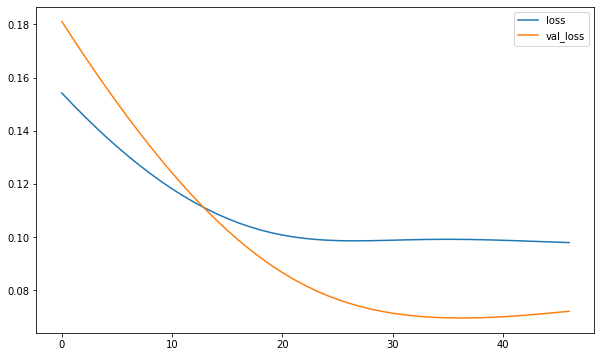

In [ ]:
# loss の 学習過程のプロット

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))

plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")

plt.legend()

In [ ]:
# テストデータを用いた最終的、パフォーマンス計測
score = model.evaluate(X_test, 
                       y_test,
                       verbose=0
                            )

print("testデータでのloss：",score) # lossの表示。

testデータでのloss： 0.09519968181848526


### 予測と結果確認

正規化を元に戻してからプロットしましょう。

ここは少しめんどくさいですが、細かく見ればわかるはずです。

- 黒が実測値
- 赤がテストデータからのモデル予測値
- 緑がモデルが予測した未来のデータ。


青はトレインデータを学習した際のモデルの予測結果。⇒あんまり意味あるとは思えません個人的に。

元の教材に記されていたので、消さずに残しておきました。

In [ ]:
sns.set(context="poster",font="Hiragino Maru Gothic Pro")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
df_week = pd.DataFrame(scaler.inverse_transform(df),
                       index=df.index,columns=df.columns)
plt.plot(df_week["2017":]["平均気温(℃)"],color="black")

#学習用データ予測結果のプロット
df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df.index[look_back:],columns=df.columns)
plt.plot(df_week_train_pred["2017":]["平均気温(℃)"],color="blue")

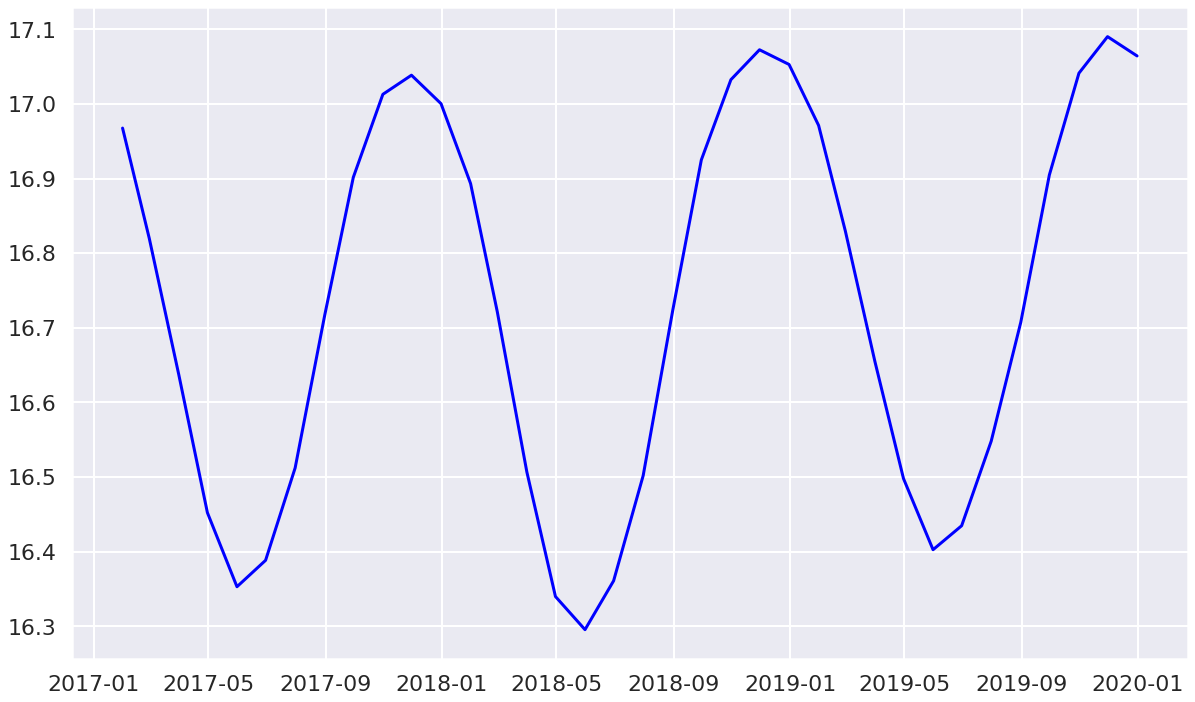

In [ ]:
#学習用データ予測結果のプロット
fig = plt.subplots(figsize=(20,12))

df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df.index[look_back:],columns=df.columns)
plt.plot(df_week_train_pred["2017":]["平均気温(℃)"],color="blue")

In [ ]:
sns.set(context="poster",font="Hiragino Maru Gothic Pro")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
df_week = pd.DataFrame(scaler.inverse_transform(df),
                       index=df.index,columns=df.columns)
plt.plot(df_week["2017":]["平均気温(℃)"],color="black")

#学習用データ予測結果のプロット
df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df_week_scale_train.index[look_back:],columns=df_week_scale_train.columns)
plt.plot(df_week_train_pred["2017":]["平均気温(℃)"],color="blue")

#評価用データ予測結果のプロット
df_week_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                 index=df_week_scale_test.index[look_back:],columns=df_week_scale_test.columns)
plt.plot(df_week_test_pred["2017":]["平均気温(℃)"],color="red")

#未来予測
future_steps = 50
X_future = [df_week_scale_test[-look_back:].values.tolist()]
y_future_list = []

for step in range(future_steps):
    y_future = model.predict(X_future)
    y_future_list.append(y_future[0])
    X_future = [X_future[0][1:] + y_future.tolist()]
    
df_week_future = pd.DataFrame(scaler.inverse_transform(y_future_list),
                              index=pd.date_range('2020-01-01', periods=future_steps, freq='W'),columns=df_week.columns)
plt.plot(df_week_future["2017":]["平均気温(℃)"],color="green")

1/1 [==============================] - 0s 28ms/step


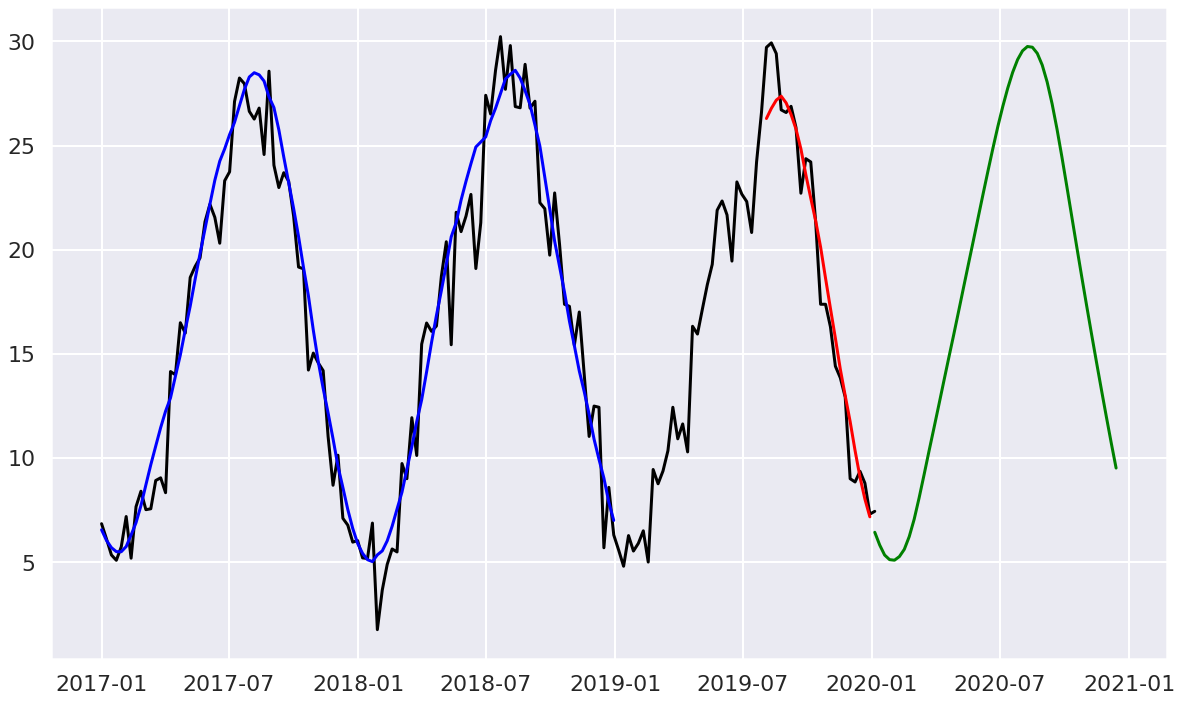

In [ ]:
sns.set(context="poster",font="Hiragino Maru Gothic Pro")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
df_week = pd.DataFrame(scaler.inverse_transform(df_week_scale),
                       index=df_week.index,columns=df_week.columns)
plt.plot(df_week["2017":]["平均気温(℃)"],color="black")

#学習用データ予測結果のプロット
df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df_week_scale_train.index[look_back:],columns=df_week_scale_train.columns)
plt.plot(df_week_train_pred["2017":]["平均気温(℃)"],color="blue")

#評価用データ予測結果のプロット
df_week_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                 index=df_week_scale_test.index[look_back:],columns=df_week_scale_test.columns)
plt.plot(df_week_test_pred["2017":]["平均気温(℃)"],color="red")

#未来予測
future_steps = 50
X_future = [df_week_scale_test[-look_back:].values.tolist()]
y_future_list = []

for step in range(future_steps):
    y_future = model.predict(X_future)
    y_future_list.append(y_future[0])
    X_future = [X_future[0][1:] + y_future.tolist()]
    
df_week_future = pd.DataFrame(scaler.inverse_transform(y_future_list),
                              index=pd.date_range('2020-01-01', periods=future_steps, freq='W'),columns=df_week.columns)
plt.plot(df_week_future["2017":]["平均気温(℃)"],color="green")

### rmse算出

面倒ですが、ここまで来たらrmse算出しますか。

In [ ]:
df_week.head(10)

,平均気温(℃)
年月日,
2010-01-03,5.600000
2010-01-10,7.057143
2010-01-17,4.514286
2010-01-24,8.371429
2010-01-31,8.757143
2010-02-07,4.242857
2010-02-14,5.914286
2010-02-21,4.942857
2010-02-28,10.900000


rmse用のデータを作成します。今回は"2019-09-01" <= 年月日 < "2019-12-29"までで。

In [ ]:
# 何行目から何行目までとかじゃない。datetimeで、2019-09-01から2019-12-29まで。
#これは予測値
df_week_test_pred2 = df_week_test_pred.query('"2019-09-01" <= 年月日 < "2019-12-29"')
df_week_test_pred2

,平均気温(℃)
年月日,
2019-09-01,27.049822
2019-09-08,26.494337
2019-09-15,25.796167
2019-09-22,24.842508
2019-09-29,23.606102
2019-10-06,22.479561
2019-10-13,21.387501
2019-10-20,20.127525
2019-10-27,18.640602


In [ ]:
#これは実測値
df_week_test = df_week.query('"2019-09-01" <= 年月日 < "2019-12-29"')
df_week_test

,平均気温(℃)
年月日,
2019-09-01,26.585714
2019-09-08,26.885714
2019-09-15,25.871429
2019-09-22,22.714286
2019-09-29,24.371429
2019-10-06,24.214286
2019-10-13,21.328571
2019-10-20,17.385714
2019-10-27,17.385714


rmse算出

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す
print("RMSE",np.sqrt(MSE(df_week_test,df_week_test_pred2)))

RMSE 1.346236659999836
